# OpenPack Tutorial | DeepConvLSTM と モデリングの基本

## [1] はじめに

このノートブックでは， (1) OpenPackの概要とタスクの説明， (2) サンプルモデルの実行を行います．
OpenPackデータセットのデータの性質を捉え， 梱包作業という行動を認識のためのモデリングのアイデアを学んで行きましょう．

### 1-1: 対象

- OpenPack Dataset， 及びOpenPack Challengeに興味のある方
- 機械学習の基本は学習済み

## [2] OpenPack Datasetの概要

**OpenPack Dataset**は， 産業ドメインにおける大規模マルチモーダルデータセットです．
物流センターの梱包作業に注目し， 16名の被験者が商品を段ボールに梱包する作業を， 深度センサやIMUセンサなど 9種類のセンサーで記録しました．
データセットのサイズは53時間超であり，産業ドメインのデータセットでは最大級です．

OpenPackの特徴を簡単にまとめました．　詳細は[HP](https://open-pack.github.io)を参照してください．

> **OpenPack Datasetの特徴**
> 1. 合計53時間を超える大規模な，産業ドメインの行動認識データセット．
> 1. 9種類のセンサの種類に加え， スマート工場に導入されているIoT機器のデータを含む．
> 1. 作業者の梱包作業の経験や， 梱包する商品など豊富なメタデータを収集．

OpenPack Datasetは，行動認識研究のためのデータセットであり，　以下の10種類の作業工程に対してラベルが付与されています． (下図のAnnotation/Operationの段)
このノートブックでは， 与えられたセンサデータに対して1秒単位でどの行動がおこなわれているかを推定します．
[Youtube](https://youtu.be/KRG5zv3ueRQ) にサンプル動画 (深度画像)をアップロードしています． こちらを見ていただければ，梱包作業の具体的な流れが掴めると思います．

> **OpenPack: Activity Class (作業工程)**
> - 100: Picking (梱包する商品を持ってくる.)
> - 200: Relocate Item Label (商品についているラベルを梱包リストに張り替える.)
> - 300: Assemble Box (段ボールを組み立てる.)
> - 400: Insert Items (組み立てた段ボールに商品を詰める.)
> - 500: Close Box (段ボールを閉じる.)
> - 600: Attach Box Label (箱番号シールを貼り付ける．)
> - 700: Scan Label (複数のバーコードをスキャンする.)
> - 800: Attaching Shipping Label (出荷ラベルをつける.)
> - 900: Put on Back Table (梱包した箱を後ろのテーブルに片付ける.)
> - 1000: Fill out Order (梱包リストの確認欄を記入し， 片付ける.)

OpenPack Datasetの主なタスクは 「梱包作業における作業工程の認識」です．
しかし，その認識は簡単ではありません．
例えば， 以下の理由によって同じ作業工程のラベルがつけられていてもその中身は非常に様々なのもが含まれることは，難しさの原因の一つです．

1. 被験者の熟練度によって，動作のスピードが大きく異なる．
1. 梱包する商品の組み合わせが毎回異なります． 商品のサイズによって使用する箱のサイズも変わります． さらに，商品の数か異なれば，箱に入れる動作の回数が変わります．
1. 作業の手順は基本的に決まっていますが，より効率的な作業のために熟練者は手順を一部変更したり， 間違いによって

![](../../../assets/img/OpenPack__KeyVisual.png)

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('KRG5zv3ueRQ', width=600, height=400)

#### Keyword: 行動認識技術
対象のユーザが行っている行動を，　センサデータから推定する技術．
日常生活を対象としたものでは 「歩く (Walk)」・「走る　(Run)」・「歯磨きをする (Brushing Teeth)」などの行動が認識対象です．
OpenPackの場合， 加速度センサや深度画像などのセンサデータから， 「箱を組み立てる (Assemble Box)」など梱包作業を構成する10工程の行動を認識します．

## [3] 行動認識のサンプルプログラムの実行

ここから先では， 左右の手首に装着したIMUセンサーで収集した加速度データを入力として， 1秒単位で10種類の作業工程のどれがおこなわれているかを推定する Nerural Networkの構築を行います．
ここでは，モデリングの基本アイデアを学ぶことに注目してほしいので，学習に必要なコードは複数ありますが，特に説明がないところはそのまま実行してください．
学習が進み，データの前処理や学習方法の変更を行いた苦なった場合は，別のチュートリアルで説明を省いたコードブロックについて理解を深めていただけると幸いです．

- 入力: 左右手首から30Hzで収集した加速度信号 60秒 (入力するTensorのShape: `(1800, 6)`)
- 出力: 1秒後ごとの作業工程ラベル (TensorのShape: `(60, 10)`)
- モデル: Neural Network (PyTorch)

### Neural Networkとは？

人間の神経細胞から着想を得た，機械学習モデルの一つです．
最初はランダムな値を主力しますが，入力データと正解ラベルの関係を「学習」することで，高精度で予測ができるようになります．，


### 行動認識モデルのモデリング

ここでは，行動認識モデルを構成するためにどのような視点を持てば良いかということを簡単にまとめます．
具体的な実装や選択は下のサンプルを実行しながら説明します．
まず，マルチモーダルな時系列データを扱うにあたって，以下の点を考慮する必要があります．

1. 時間方向の依存関係
    1. 考慮する範囲 (1秒間?，10秒間?) 
    1. 順方向の時間発展 (時間を進める方向) のみ考慮するか，逆方向 (時間を巻き戻す方向)も考慮するか?
1. モダリティの扱い
    1. センサーフュージョン (両手の動きをまとめて特徴抽出する? まずは右左別々に特徴抽出を行いあとで組み合わせる？)
    1. 他のモダリティ (動画，IoT デバイスのログ, etc) との組み合わせ方


このチュートリアルで全てを扱うことは難しいので，**1. 時間方向の依存関係** について考えていきたいと思います．

### OpenPack Datasetの梱包作業に着目したモデリングのポイント

基本的には上の2項目と同じですが，よりOpenPackのデータ特化したポイントを説明します．

- 手だけを使った動作が中心です．そのため，加速度データだけでは非常に似通った動作が多く存在します．
    - e.g.) "Assemble Box" / "Close Box" ==> ガムテープで箱を閉じる動作.
    - 特徴抽出する範囲をできるだけ広くとって，前後の作業工程を手がかりに注目した時刻の動作を推定することが有効だと考えられます．
- 行動の出現順序は基本的に決まっている.
    - 作業手順が決まっているので，行動クラスの出現順序はおおよそ決まっています．
    - この出現順序は予測を行う上で大きなヒントとなります．
    - (注意) ある程度精度が高まると，作業ミスなどで通常の順序から外れる場合が出てきます．この部分をどう扱うかがより精度を高めるために重要になります．

------
ここからは，実装パートになります．

## [4] 環境の初期化 (Notebookを開いて初回のみ実行)
細かい説明は省きます．ひとまず，以下のコードを順番に実行してください．

### 4-1: Download Code and Install `openpack-torch` 

In [ ]:
# サンプルコードのダウンロード
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [ ]:
# 関連パッケージのダウンロード
! cd /content/openpack-torch/ && pip install .

### 4-2: データセットのダウンロード

In [ ]:
# ダウンロード先: /content/data/datasets/
! mkdir -p /content/data/datasets/
! optk-download -d /content/data/datasets -v v0.2.1 -s atr-qags,openpack-operations

### 4-3: モジュールのインポート

In [1]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict, Optional


import hydra
import numpy as np
import openpack_toolkit as optk
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
from torch import nn
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize_config_dir, compose
from omegaconf import DictConfig, OmegaConf

from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-08-24 00:51:43 | INFO | __main__ | info
2022-08-24 00:51:43 | WARNING | __main__ | warning


### 4-4: 設定ファイルの読み込み
パラメータなどのデフォルト値を読み込みます．こちらも詳細な説明は省きます．深層学習でモデルを組む場合は，非常に多くのハイパーパラメータ (手動で設定すべきパラメータ) があるため，これらを管理することは，実験の再現性と効率的を高めるために重要です．この問題を解決するために様々なツールが提案されていますが，ここでは　[hydra](https://hydra.cc/) を使用しています．

In [3]:
# データセットに関連するパラメータを読み込む
optorch.configs.register_configs()

# 学習・モデル関係のパラメータを読み込む
config_dir = Path("/content/openpack-torch/examples/deep-conv-lstm/configs")
overrides = [
    "mode=train",
    "issue=I01-EXP1-V1-nb", # subdirectry for logging
    "debug=false", # Set true when you want to make submission file to submit to the Development Phase form.
    "datarootdir=/content/data", # data directory, dataset and logs are loaded from and stored to this directory.
    "hydra/job_logging=custom",
    "hydra/hydra_logging=disabled"
]

with initialize_config_dir(version_base=None, config_dir=str(config_dir)):
    cfg = compose(
        config_name="deep-conv-lstm.yaml",
        overrides=overrides,
    )

In [4]:
print(OmegaConf.to_yaml(cfg.path))

openpack:
  version: v0.2.1
  rootdir: ${datarootdir}/datasets/openpack/${.version}
logdir:
  rootdir: ${datarootdir}/log/${dataset.name}/${model.name}/${issue}
  model: ${path.logdir.rootdir}/model.pth
  predict: ${path.logdir.rootdir}/pred/{user}-{session}
  summary:
    test: ${path.logdir.rootdir}/summary.csv
    submission: ${path.logdir.rootdir}/summary_submission.csv



## [5] モデルの定義

### 5-1: ベースとするモデルの概要 (DeepConvLSTM)

このチュートリアルでは，DeepConvLSTM という2016年に発表されたモデルをベースに，様々なモデルを作っていきたいと思います．
このモデルは，現在でもベースライン手法として多くの研究で利用されています．
まず，畳み込み層 (`Conv2d`) で局所的な特徴を抽出した後，時系列モデリングを行うことができるLSTM層で長期的な依存関係を抽出することで，短期的な依存関係と長期的な依存関係の両方を考慮するように設計されています．

参考: [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition (Sensors, 2016)](https://www.mdpi.com/1424-8220/16/1/115) 

### 5-2: モデルの変更パターン

今回は次の3種類を用意しました．

1. CNNのみ
    1. 畳み込みフィルタのサイズを変更して，特徴を抽出する時間の長さを変える.)
    1. CNN層の数を変える.
1. DeepConvLSTM (論文で提案されているモデル)
1. 双方向LSTM (LSTM層を，順方向&逆方向の両方を考慮するものを使用)


#### 5-2-1: CNNのみ (ver.1) 

CNNのみを使用したモデルです．
特徴を抽出する時間の範囲は，(A) kernel size，(B) 畳み込み層の数を変更することで変えることができます．
畳み込み層はPyTorchで `Conv2d()` として定義されています．

##### 実験1-A: Kernel Sizeの変更

センサーのサンプリングレートは30Hzです．
つまり，Kernel Sizeを `ks=30` とすると，一回の畳み込み演算で1秒間の範囲から特徴抽出をすることができます．
実験では，以下の値に設定してモデルを学習してみて結果を比べてみましょう．
ちなみに，OpenPackの作業工程の継続時間は作業工程により異なりますが，通常2秒 ~ 15秒です．

- `ks=5` (0.16秒間; 論文のパラメータ)
- `ks=15` (0.5秒間)
- `ks=30` (1.0秒間)
- `ks=60` (2.0秒間)


##### 実験1-B: 畳み込み層の数 (`num_conv_layers`)

畳み込み層を重ねることでも，特徴抽出の範囲を広げることができます．
以下の値を試してみてください．

- `num_conv_layers = 1`
- `num_conv_layers = 4` (論文のパラメータ)
- `num_conv_layers = 8`

##### 実験1-C: Kernel Size x 畳み込み層の数

「Kernek Size」と「畳み込み層の数」はどちらも特徴を抽出する範囲を変えることができます．
また，この２つのパラメータの組み合わせ方もとても重要です．
例えば，kernel sizeは小さく，層の数は多く設定することで，細かな特徴を捉えつつ徐々に長期的な依存関係を捉えることができます．
画像系のモデルでは，しばしばこのアプローチが採用されてきました．
逆に，Kernel Sizeを大きく設定し，層の数を減らすアプローチでは，畳み込む範囲が広いので局所的なノイズに強くすることができます．
どのようなアプローチが良いか，実験してみてください．

In [13]:
class DeepConvLstmV1(nn.Module):
    """CNNだけを使用するモデル
    """
    def __init__(self, in_ch: int = 6, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN (畳み込み層) --
        # *** Edit Here ***
        # NOTE: 実験1-A: Kernel Size (注意: 奇数を指定)
        ks = 5
        # NOTE: 実験1-B: 使用する畳み込み層の数 (Default: 4)
        num_conv_layers = 4
        # ******************
        num_conv_filter = 64 # 各層の畳み込みフィルタの数 (Default: 64)
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else num_conv_filter 
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, num_conv_filter, kernel_size=(ks, 1), padding=(ks//2, 0)),
                    nn.BatchNorm2d(num_conv_filter),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [3] 出力層 --
        self.out8 = nn.Conv2d(
            num_conv_filter,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)
            
        # -- [3] 出力層 --
        x = self.out8(x)
        return x


#### 5-2-2: DeepConvLstm (ver.2)

論文で提案されているモデルの構成です．ver.1に対して，LSTM層が追加されています．
LSTMによって，長期的な依存関係を学習することができるようになります．

In [6]:
class DeepConvLstm(nn.Module):
    """論文で提案されている構成.
    """
    def __init__(self, in_ch: int = 6, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN (畳み込み層) --
        # *** Edit Here ***
        num_conv_layers = 4 # 使用する畳み込み層の数 (Default: 4)
        num_conv_filter = 64 # 各層の畳み込みフィルタの数 (Default: 64)
        ks = 5 # 畳み込みフィルタのサイズ; kernel size, 
        # ******************
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***        
        hidden_units = 128 # LSTM層の隠れニューロンの数
        # ******************
        
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True)
        self.lstm7 = nn.LSTM(hidden_units, hidden_units, batch_first=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] 出力層 --
        self.out8 = nn.Conv2d(
            hidden_units,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM (!! 追加 !!) --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3) 
        
        # -- [3] 出力層 --
        x = self.out8(x)
        return x


#### 5-2-3: DeepConvLstm (ver.3)

ver.2のLSTM層を，双方向 (時間の進む&戻る) の依存関係を考慮する設定に書き換えました．
この変更により，注目した部分の行動の推定を，前の作業工程の情報だけでなく，これから起こる作業工程の情報も考慮して推定することができるようになります．

In [7]:
class DeepConvLstmV3(nn.Module):
    def __init__(self, in_ch: int = 6, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN (畳み込み層) --
        # *** Edit Here ***
        num_conv_layers = 4 # 使用する畳み込み層の数 (Default: 4)
        num_conv_filter = 64 # 各層の畳み込みフィルタの数 (Default: 64)
        ks = 5 # 畳み込みフィルタのサイズ; kernel size, 
        # ******************
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***        
        hidden_units = 128 # LSTM層の隠れニューロンの数
        # ******************
        
        # NOTE: bidirectionalをTrueに変更
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True, bidirectional=True)
        self.lstm7 = nn.LSTM(hidden_units*2, hidden_units, batch_first=True,  bidirectional=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] 出力層 --
        self.out8 = nn.Conv2d(
            hidden_units * 2,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3) 
        
        # -- [3] 出力層 --
        x = self.out8(x)
        return x


## [6] モデルの学習

### 6-1: DataModuleの定義
データセットの読み込みと前処理を担当するモジュールを初期化します．編集なしで，そのまま実行してください．

In [8]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 6-2: Lightning Moduleの定義 (編集必要!)
学習ループの監督を担当するモジュール．DeepConvLSTMを定義したセルを実行した後に実行します．
`init_modeol()` メソッドの中で，実行したいモデルをコメントアウトしてください．

In [34]:
class MyModelLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        """ モデルの初期化
        
        上で定義したモデル ``DeepConvLSTM()`` のインスタンスを生成する．
        実験したいモデルのコメントアウトを外してください．
        """
        # !! ここを編集 !!
        # NOTE: 実行したいモデルを選択
        # model = DeepConvLstmV1()
        # model = DeepConvLstm()
        model = DeepConvLstmV3()
        return model
    
    
    def init_criterion(self, cfg: DictConfig):
        """評価指標を定義する．
        """
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.annotation.classes.classes) if c.is_ignore]
        
        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        """学習ループの定義． ミニバッチを受け取り，lossの計算までを記述．
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        """推論ループの定義．ミニバッチを受け取り，モデルの推論結果の出力を返す．
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs


In [35]:
def test(cfg: DictConfig, datamodule: pl.LightningDataModule, trainer: pl.Trainer):
    datamodule.setup("test")
    dataloaders = datamodule.test_dataloader()
    split = cfg.dataset.split.test

    # テストデータに対して推論
    outputs = dict()
    for i, dataloader in enumerate(dataloaders):
        user, session = split[i]
        logger.info(f"test on {user}-{session}")

        trainer.test(plmodel, dataloader)

        # save model outputs
        pred_dir = Path(
            cfg.path.logdir.predict.format(user=user, session=session)
        )
        pred_dir.mkdir(parents=True, exist_ok=True)

        for key, arr in plmodel.test_results.items():
            path = Path(pred_dir, f"{key}.npy")
            np.save(path, arr)
            logger.info(f"save {key}[shape={arr.shape}] to {path}")

        outputs[f"{user}-{session}"] = {
            "t_idx": plmodel.test_results.get("t"),
            "y": plmodel.test_results.get("y"),
            "unixtime": plmodel.test_results.get("unixtime"),
        }
    
    # 評価スコアを計算
    df_summary = eval_operation_segmentation_wrapper(
        outputs, OPENPACK_OPERATIONS,
    )
       
    return outputs, df_summary


def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


### 6-3: モデルの学習に必要なモジュールの初期化
(1)モデル, (2) データセット, (3) Trainer を初期化します．

In [36]:
# 再現性を高めるためモデル初期化の直前にランダムシードの初期化を行う.
optorch.utils.reset_seed(seed=0)

device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg) # (1) データセット
plmodel = MyModelLM(cfg).to(dtype=torch.float, device=device) # (2) モデルの初期化

2022-08-24 00:59:34 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


In [37]:
# NOTE: 学習させたいエポック数を指定
num_epoch = 50 

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# 初期化したモデルを表示
plmodel

MyModelLM(
  (net): DeepConvLstmV3(
    (conv_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(6, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (lstm6): LSTM(64, 128, batch_fir

### 6-4: モデルの学習

#### 6-4-1: 学習前のモデルの出力の確認

In [39]:
outputs, df_summary = test(cfg, datamodule, trainer)

2022-08-24 00:59:36 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 00:59:36 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 00:59:36 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 00:59:36 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-08-24 00:59:36 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-08-24 00:59:36 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f05497cd520>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f05497c32b0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0549775490>}
2022-08-24 00:59:36 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-08-24 00:59:36 | INFO | __main__ | test on U0106-S0100
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-08-24 00:59:36 | INFO | __main__ | 

In [40]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
36,avg/macro,-1,0.010982,0.100000,0.019790,None,all
37,avg/weighted,-1,0.012059,0.109815,0.021732,None,all
38,Picking,100,0.000000,0.000000,0.000000,564,all
39,RelocateItemLabel,200,0.000000,0.000000,0.000000,936,all
40,AssembleBox,300,0.000000,0.000000,0.000000,1039,all
41,InsertItems,400,0.000000,0.000000,0.000000,493,all
42,CloseBox,500,0.109815,1.000000,0.197898,659,all
43,AttachBoxLabel,600,0.000000,0.000000,0.000000,331,all
44,ScanLabel,700,0.000000,0.000000,0.000000,679,all
45,AttachShippingLabel,800,0.000000,0.000000,0.000000,463,all


In [41]:
# 可視化したいセグメント
key = "U0106-S0500"

# 予測結果の取得
unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(18, 1800), t_idx=(18, 1800), y=(18, 11, 1800), y_softmax=(18, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


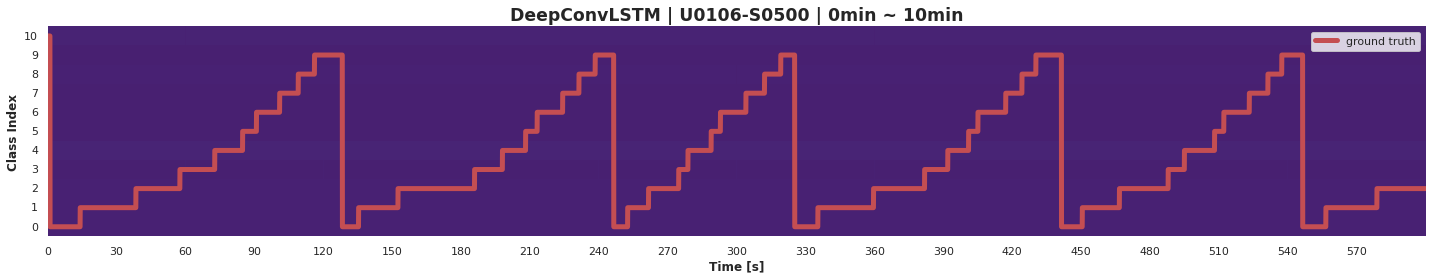

In [42]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

#### 6-4-2: 学習

In [43]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-08-24 00:59:38 | INFO | __main__ | Start training for 50 epochs.
2022-08-24 00:59:39 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 00:59:39 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 00:59:40 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 00:59:40 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False)
2022-08-24 00:59:40 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0549578340>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0549583790>}
2022-08-24 00:59:40 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-08-24 00:59:40 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
------------------

#### 6-4-5: 学習曲線の表示

モデルの学習がうまく行っているか確認するために，epochごとのlossの変化をプロットします．
lossがepochが進むにつれて徐々に下がっていくことを確認してください．

In [44]:
df = pd.concat([
    pd.DataFrame(plmodel.log["train"]),
    pd.DataFrame(plmodel.log["val"]),
],axis=1,)
df.index.name = "epoch"

In [45]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.250871,0.224052,2.386348,0.153831
1,2.009070,0.364722,2.353751,0.182245
2,1.885238,0.401546,2.152828,0.290451
3,1.811016,0.427331,2.010582,0.337035
4,1.759136,0.440674,1.946284,0.353214


Training Log

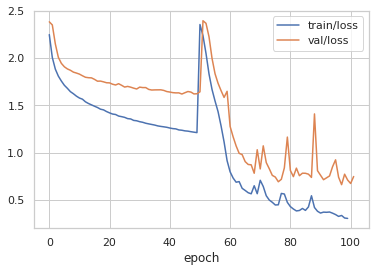

In [46]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

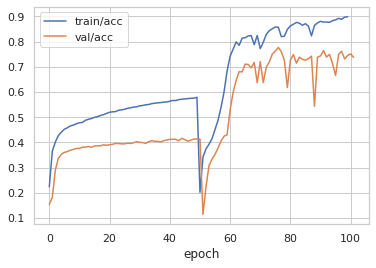

In [47]:
df[["train/acc", "val/acc"]].plot()
plt.show()

### 6-5: 評価

In [48]:
# テストデータで評価
outputs, df_summary = test(cfg, datamodule, trainer)

2022-08-24 01:02:13 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 01:02:13 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 01:02:13 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-08-24 01:02:13 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-08-24 01:02:13 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-08-24 01:02:13 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f054945ccd0>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f05494044c0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f0549425e80>}
2022-08-24 01:02:13 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-08-24 01:02:13 | INFO | __main__ | test on U0106-S0100
2022-08-24 01:02:13 | WARNING | openpack_torch.data.datasets | No preprocessing is

#### 評価指標:

- Precision
- Recall
- F値 (F1-measure)

F値のマクロ平均 (f1, name=avg/macoro)に注目

In [49]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
36,avg/macro,-1,0.761953,0.734182,0.737017,None,all
37,avg/weighted,-1,0.765370,0.751375,0.748637,None,all
38,Picking,100,0.636029,0.920213,0.752174,564,all
39,RelocateItemLabel,200,0.692038,0.845085,0.760943,936,all
40,AssembleBox,300,0.845444,0.705486,0.769150,1039,all
41,InsertItems,400,0.672348,0.720081,0.695397,493,all
42,CloseBox,500,0.868726,0.682853,0.764656,659,all
43,AttachBoxLabel,600,0.651934,0.356495,0.460937,331,all
44,ScanLabel,700,0.709884,0.814433,0.758573,679,all
45,AttachShippingLabel,800,0.817757,0.755940,0.785634,463,all


#### 可視化

In [50]:
# 可視化したいセグメント
key = "U0106-S0500"

# 予測結果の取得
unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(18, 1800), t_idx=(18, 1800), y=(18, 11, 1800), y_softmax=(18, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


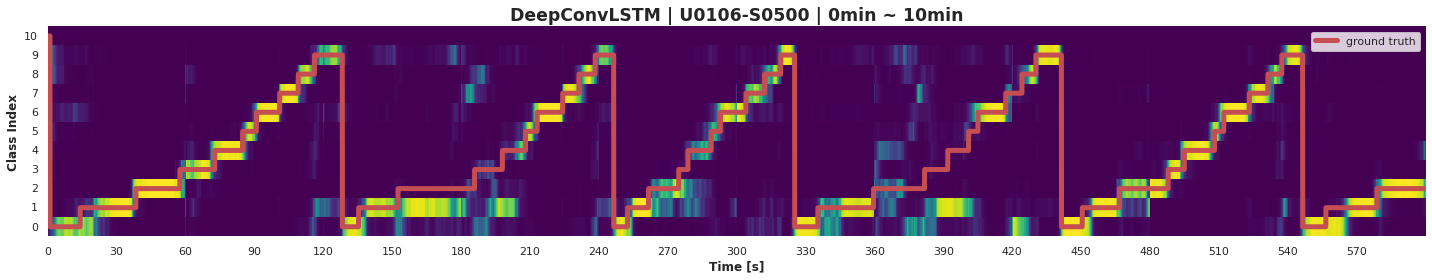

In [51]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()